In [368]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import sys
sys.path.append('../../lib/python')

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

import numpy as np
import matplotlib.pyplot as plt
from PySpice.Unit import *
import unittest

import SchemDraw as schemdraw
import SchemDraw.elements as elm

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
#from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice", "transistor")
spice_library = SpiceLibrary(spice_libraries_path)

## setup path to kicad schema
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath( 'main', 'main.cir' )
NETLIST = str( kicad_netlist_path )

In [369]:
## schema definitions
d = schemdraw.Drawing()
op = d.add(elm.Opamp)
d.add(elm.Line(xy=op.out, l=.75, rgtlabel='$v_{out}$'))

d.add(elm.Line('left', xy=op.in1, l=.75))
d.add(elm.Line('up', l=1.5))
d.add(elm.Dot)
R1 = d.add(elm.Resistor('left', label='$R_1$'))
R5 = d.add(elm.Resistor('down', label='$R_5$', rotation=90, rotation_mode='default'))
d.add(elm.Dot)
d.add(elm.Resistor('down', label='$R_6$', rotation=90, rotation_mode='default'))
d.add(elm.Ground)

l = d.add(elm.Line('left', xy=R1.end, l=1.5))
d.add(elm.Line('left', l=.5, lftlabel='$v_{in}$'))
d.add(elm.Line('down', xy=l.end, l=1.5))
POT = d.add(elm.Potentiometer('down'))
POT.add_label('$RV_{(R3/R4)}$', loc='center', ofst=[0,-1], align=('right','bottom'))
d.add(elm.Ground,xy=POT.end)
d.add(elm.Line('right', xy=POT.tap, tox=R5.end))
d.add(elm.Line('right', xy=POT.tap, tox=op.in2-.75))
d.add(elm.Line('up', l=0.5))
d.add(elm.Line('right', l=.75))
Rf = d.add(elm.Resistor('right', xy=R1.start, tox=op.out+.5, label='$R_2$'))
d.add(elm.Line('down', toy=op.out))
end = d.add(elm.Dot)



In [370]:
diffamp = schemdraw.Drawing()
diffamp_op = diffamp.add(elm.Opamp)
diffamp.add(elm.Line(xy=op.out, l=.75))
diffamp.add(elm.Line('left', xy=op.in1, l=.75))
diffamp.add(elm.Line('up', l=1.5))
diffamp.add(elm.Dot)
diffamp_R1 = diffamp.add(elm.Resistor('left', label='$R_1$', lftlabel='$v_{1}$'))
diffamp_Rf = diffamp.add(elm.Resistor('right', xy=diffamp_R1.start, tox=diffamp_op.out+.5, label='$R_2$'))
diffamp.add(elm.Line('down', toy=diffamp_op.out))
diffamp.add(elm.Dot)

diffamp.add(elm.Line('left', xy=diffamp_op.in2, l=.75))
diffamp.add(elm.Line('down', l=1.5))
diffamp_dot = diffamp.add(elm.Dot)

diffamp_R3 = diffamp.add(elm.Resistor('right', label='$R_3$'))
diffamp.add(elm.Ground)
X = diffamp.add(elm.Resistor('left', xy=diffamp_dot.start, label='$R_4$', lftlabel='$v_{2}$'))


In [371]:
class XU1(SubCircuitFactory):
    __name__ = 'XU1'
    __nodes__ = ( 'OUT', 'INVERTING', 'NON_INVERTING', 'POWER_NEGATIVE', 'POWER_POSITIVE' )
    def __init__(self):
        super().__init__()
        self.X('1', 'OPA2134', 'NON_INVERTING', 'INVERTING', 'POWER_POSITIVE', 'POWER_NEGATIVE', 'OUT' )

class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

# show the netlist
parser = SpiceParser(path=NETLIST)


In [372]:
from sympy import symbols, sqrt, exp, diff, integrate, pprint, latex, simplify, Eq                                                                                                                      
R1, R2, R3, R4, Vin, Vin2, Vout = symbols('R1 R2 R3 R4 Vin Vin2, Vout', real=True)
eq_diff = (1+R2/R1) * (R4/(R4+R3)) * Vin2 - (R2/R1) * Vin 
eq_paralell_resistor =  1 /( (1/R1) + (1/R2) ) 

![module](https://img.shields.io/badge/module-mischer-yellow)
![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

# *kontrast*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

## *table of contents*

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*reference*](#lreference)
* [*changelog*](#changelog)

<br/><br/>

## *about*

kontrast ist a simple mixer utility module. it can be used as a **mixer**, **attenuator** or **attenuverter** for ac or dc signals. the function depends on the patching and settings of the potentiometers. an attenuverter is used in different modules like the  Serge VCS, Maths and also in the polivoks filter. while this module can be used as a simple mixer you can also adjust cv signals. such a signal can be simply attenuated or inverted. when feeding in a positive singal slope (for example from an adsr). the signal will be turned to a neagative dc singal. if the inpout signal is ac coupled the signal will be inverted. the function is the setting on the potentiometer of the channel. when the potentiometer is at center position. the output signal is attenuated to zero. no output singal is present. when turning to the right. the signal will be stronger until the output signal is equal to the input signal. when turning the potentiomenter to the left, the output signal will be phase shifted by 180°. when you turn the potentiometer to full left the output signal will be the inverted input signal. all the inputs are mixed to the output signal; unless you connect the output of a channel. then this output does not accure on the mixed signal.

the attenuverter is build around a differential amplifier with an opamp. 

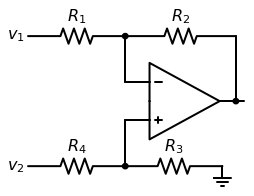

In [373]:
diffamp.draw()

In [374]:
Eq( Vout, eq_diff)

Eq(Vout, R4*Vin2*(1 + R2/R1)/(R3 + R4) - R2*Vin/R1)

the circuit of the attenuverter is based on the opamp dfferential amplifer. the two resistors at the non-inverting inputs are replaced with a potentiometer. the potentiometer is configured as a voltage divider and replace R3 and R4 from the differential amplifier. when the position of the potentiometer is adjusted, the output voltage will change or invert. at the center position  the output is zero volrs. the response to the potentiometer is linear. we can make it an centered s-curve by adding two parallel resistors (R5,R6) to the potentiometer [[2][2]].

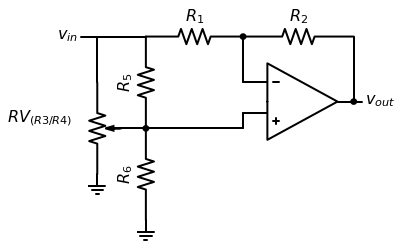

In [375]:
d.draw()

a simulation with the resistance at RV 1 changed from 0-100%. first run is the linear result. the second run is done with the resistors R5 and R6 added. This results in a s curve. the shape of the curve can be changed with the values of the resistors.

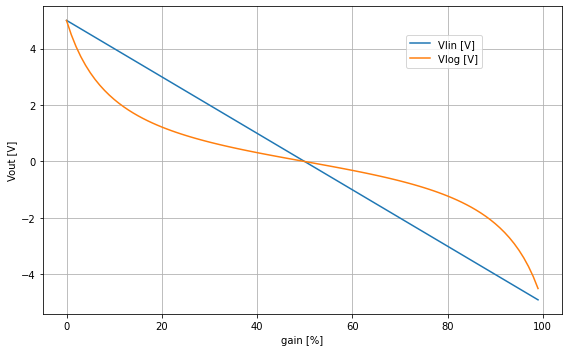

In [376]:
Vlin = []
Vlog = []

R1val = 10@u_kOhm
R2val = 10@u_kOhm
RVval = 10@u_kOhm
R5val = 2.2@u_kOhm
RVstep = 100@u_Ohm

for Rtemp in np.arange(1@u_Ohm, RVval, RVstep):
    R3t = Rtemp
    R4t = RVval - Rtemp
    Vtemp = eq_diff.subs(R1, R1val).subs(R2, R2val).subs(R3, R3t).subs(R4, R4t).subs(Vin, 5).subs(Vin2, 5)
    Vlin.append(Vtemp)

for Rtemp in np.arange(1@u_Ohm, RVval, RVstep):
    R3t =  eq_paralell_resistor.subs(R1, Rtemp).subs(R2, R5val)
    R4t = eq_paralell_resistor.subs(R1, RVval - Rtemp).subs(R2, R5val) 
    Vtemp = eq_diff.subs(R1, R1val).subs(R2, R2val).subs(R3, R3t).subs(R4, R4t).subs(Vin, 5) .subs(Vin2, 5)   
    Vlog.append(Vtemp)

figure, ax = plt.subplots(figsize=(8, 5))
ax.plot(Vlin)  # the pot position from 0 .. 1
ax.plot(Vlog)  # the pot position from 0 .. 1
ax.legend(('Vlin [V]', 'Vlog [V]'), loc=(.7, .8))
ax.grid()
ax.set_xlabel('gain [%]')
ax.set_ylabel('Vout [V]')
plt.tight_layout()
plt.show()

## construction

because the channel is silent at potentometer center position, it would be nice to use a potentometer that has a center decent. such potientometers for panel mount are rare. 


<img src="main/main.svg"/>


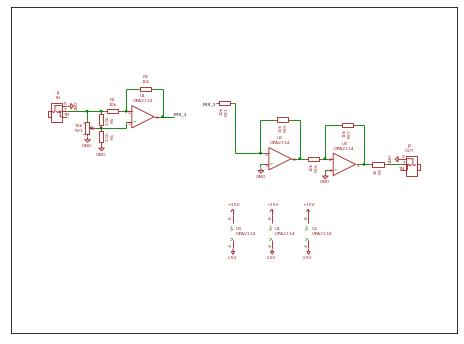

In [377]:
from kicad import schema
fn = 'main/main.sch'
sch = schema.Sch(fn)

from kicad import matplotlib_renderer
fig, ax = plt.subplots(figsize = (8, 6))
# Add a bit of margin since matplotlib chops off the text otherwise
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)
matplotlib_renderer.render_to_ax(ax, sch)
plt.show()

In [378]:
circuit = parser.build_circuit(ground='GND')
circuit.include(spice_library['OPA2134'])
circuit.V('1', '+15V', circuit.gnd, 15@u_V)
circuit.V('2', '-15V', circuit.gnd, -15@u_V)

for subcircuit in ( XU1(), VoltageDivider(R=10@u_kOhm,w=0) ):
    circuit.subcircuit(subcircuit)

#print(str(circuit))


simulation to check the attenuation function. 

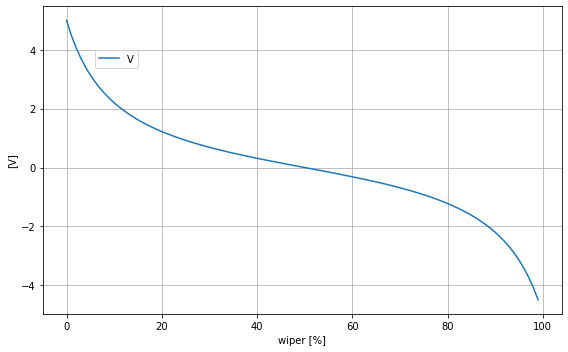

In [379]:
steps = np.arange( 1, 0, -0.01 )
results = []

for s in steps:

    circuit = parser.build_circuit(ground='GND')
    circuit.include(spice_library['OPA2134'])
    circuit.V('1', '+15V', circuit.gnd, 15@u_V)
    circuit.V('2', '-15V', circuit.gnd, -15@u_V)

    for subcircuit in ( XU1(), VoltageDivider(R=RVval,w=s) ):
        circuit.subcircuit(subcircuit)

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()

    results.append( float( analysis['Net-_J2-PadT_'] ) )

figure, ax = plt.subplots(figsize=(8, 5))
ax.plot(results)  # input
ax.legend(('Vout [V]'), loc=(.1, .8))
ax.grid()
ax.set_xlabel('wiper [%]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()


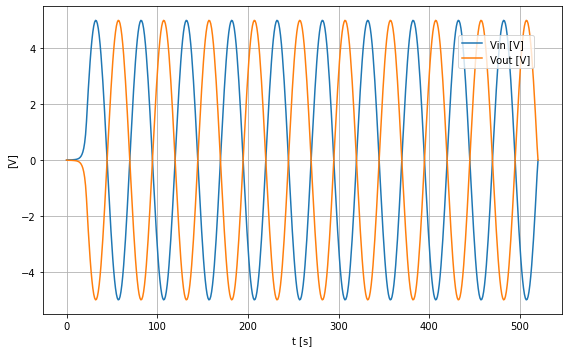

In [380]:
parser = SpiceParser(path=NETLIST)
circuit = parser.build_circuit(ground='GND')
circuit.include(spice_library['OPA2134'])
circuit.V('1', '+15V', circuit.gnd, 15@u_V)
circuit.V('2', '-15V', circuit.gnd, -15@u_V)

for subcircuit in ( XU1(), VoltageDivider(R=100@u_kOhm,w=0) ):
    circuit.subcircuit(subcircuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=20@u_us, end_time=10@u_ms)

figure, ax = plt.subplots(figsize=(8, 5))
ax.plot(analysis['Net-_J1-PadT_'])  # input
ax.plot(analysis['/MIX_1'])  # input
#ax.plot(analysis['Net-_RV1-Pad2_'])  # voltage divider output
ax.legend(('Vin [V]', 'Vout [V]', 'Vdiv [V]'), loc=(.8, .8))
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()

## *calibration*

there is no calibration needed. but the potentiomenter knobs have to be aliged to center position.

## *usage*

the input jacks are wired to 5 volts when nothing is connected.

all channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when you turn the pot knob counter clockwise the signal is inverted.


## *reference*

* Rod Elliott (ESP) [Beginners' Guide to Potentiometers][2] 

[1]: https://wikipedia.org
[2]: https://sound-au.com/pots.htm

## *history*



---
[![CC BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)](https://creativecommons.org/licenses/by-sa/4.0/)